In [1]:
!pip install transformers
!pip install accelerate -U
!pip install evaluate
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import nltk
import torch
import re
import evaluate

import numpy as np
import pandas as pd


from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [5]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [14]:

df_train = pd.read_csv('bugs-train.csv')

In [8]:
df_train.head()

,bug_id,summary,severity
0,365569,Remove workaround from bug 297227,normal
1,365578,Print Preview crashes on any URL in gtk2 builds,critical
2,365582,Lines are not showing in table,major
3,365584,Firefox render ÛÏsimplified ArabicÛ font fa...,normal
4,365597,Crash [@ nsINodeInfo::NodeInfoManager],critical


In [21]:
label_encoder = LabelEncoder()

y_numeric = label_encoder.fit_transform(df_train['severity'])
X_train, X_test, y_train, y_test = train_test_split(df_train, y_numeric, test_size=0.25, random_state=42, stratify=y_numeric)

In [22]:
category_list = [words for words in df_train['severity'].to_list()]
category_list = list(set(category_list))[::-1]
label2id = {item: index for index, item in enumerate(category_list)}
id2label = {index: item for index, item in enumerate(category_list)}

In [11]:
label2id

{'blocker': 0,
 'trivial': 1,
 'normal': 2,
 'critical': 3,
 'enhancement': 4,
 'major': 5,
 'minor': 6}

In [23]:
X_train['labels'] = X_train['severity'].replace(label2id)
X_test['labels'] = X_test['severity'].replace(label2id)

In [24]:
english_stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in english_stop_words]
    return ' '.join(filtered_tokens)

X_train['summary_preprocessed'] = X_train['summary'].apply(preprocess)
X_test['summary_preprocessed'] = X_test['summary'].apply(preprocess)

In [25]:
x_train = X_train.drop(['summary','severity'], axis=1).reset_index(drop=True)
x_test = X_test.drop(['summary','severity'], axis=1).reset_index(drop=True)
x_train.head()

,bug_id,labels,summary_preprocessed
0,724241,3,css mozselection textshadow ignored
1,622386,2,inertia enabled scrolling trackpad right switc...
2,387522,3,native json support
3,665387,3,remove unused variable document nshtml5treeope...
4,402565,4,js reload iframe parent loads subframe old que...


In [15]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [16]:
def preprocess_function(data_frame):
    return tokenizer(data_frame["summary_preprocessed"], truncation=True)

In [17]:
train_dataset = Dataset.from_pandas(x_train)
test_dataset = Dataset.from_pandas(x_test)

tokenized_train_df = train_dataset.map(preprocess_function, batched=True)
tokenized_test_df = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/119998 [00:00<?, ? examples/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

In [18]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [19]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=len(x_train['labels'].value_counts()), id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
training_args = TrainingArguments(
    output_dir= '/content/drive/MyDrive/',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_df,
    eval_dataset=tokenized_test_df,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.514300,0.519765,0.861025
2,0.481900,0.513858,0.863325


TrainOutput(global_step=15000, training_loss=0.5162584299723307, metrics={'train_runtime': 1333.5537, 'train_samples_per_second': 179.967, 'train_steps_per_second': 11.248, 'total_flos': 2261544839923476.0, 'train_loss': 0.5162584299723307, 'epoch': 2.0})

In [33]:
output_dir = '/content/drive/MyDrive/your_model_directory'
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


('/content/drive/MyDrive/your_model_directory/tokenizer_config.json',
 '/content/drive/MyDrive/your_model_directory/special_tokens_map.json',
 '/content/drive/MyDrive/your_model_directory/vocab.txt',
 '/content/drive/MyDrive/your_model_directory/added_tokens.json',
 '/content/drive/MyDrive/your_model_directory/tokenizer.json')

In [7]:
!pip install pandarallel


  Preparing metadata (setup.py) ... done
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16673 sha256=b3ad76278c3610e849236c33e0e42cf5c143c3ef078d80067540d83ca887ad31
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from tqdm.auto import tqdm
from pandarallel import pandarallel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from collections import defaultdict

from wordcloud import WordCloud


In [11]:
# Use tqdm with apply to add a progress bar
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [12]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 2.6 MB/s eta 0:00:00


In [13]:
from sentence_transformers import SentenceTransformer

In [26]:
model = SentenceTransformer('distilbert/distilbert-base-uncased-finetuned-sst-2-english')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [27]:
english_stop_words = set(stopwords.words('turkish'))
def remove_stop_words(text):
  text = text.lower()
  text = re.sub(r'[^\w\s]', '', text)
  tokens = word_tokenize(text)
  filtered_tokens = [word for word in tokens if word.lower() not in tukish_stop_words]
  return ''.join(filtered_tokens)

In [28]:
from imblearn.under_sampling import RandomUnderSampler

In [39]:
rus = RandomUnderSampler(random_state =  42)

In [15]:
df_train.head()

,bug_id,summary,severity
0,365569,Remove workaround from bug 297227,normal
1,365578,Print Preview crashes on any URL in gtk2 builds,critical
2,365582,Lines are not showing in table,major
3,365584,Firefox render ÛÏsimplified ArabicÛ font fa...,normal
4,365597,Crash [@ nsINodeInfo::NodeInfoManager],critical


In [40]:
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = rus.fit_resample(X_test, y_test)
X_train_resampled.head()

,bug_id,summary,severity,labels,summary_preprocessed
0,712929,Type Inference breaks certain JavaScript code,blocker,0,type inference breaks certain javascript code
1,530380,Avoid slow path painting on Hildon,blocker,0,avoid slow path painting hildon
2,1041511,Can't access 'localhost:port' while on a remot...,blocker,0,cant access localhostport remote page bug 3544...
3,715332,"IonMonkey: Assertion failure: Tag == OP2, at ....",blocker,0,ionmonkey assertion failure tag op2 ionarmasse...
4,993462,Call screen is not visible when making a call ...,blocker,0,call screen visible making call phone app


In [29]:
X_train_resampled = X_train


In [31]:
training_embeddings = []
batch_size = 16
for i in tqdm(range(0,len(X_train_resampled), batch_size)):
  batch_texts = X_train_resampled.iloc[i: i+ batch_size]['summary_preprocessed'].to_list()
  sentence_embeddings = model.encode(batch_texts)
  training_embeddings += list(sentence_embeddings)

X_train_resampled['embeddings']= training_embeddings

  0%|          | 0/7500 [00:00<?, ?it/s]

In [49]:
X_train_resampled.tail()

,bug_id,summary,severity,labels,summary_preprocessed,embeddings
3677,383864,CSS formatting ignored when copying and pastin...,trivial,1,css formatting ignored copying pasting prestyl...,"[-0.23509197, 0.7042168, -0.16169028, -0.14652..."
3678,569181,Change nsCOMPtr<nsMediaList> to nsRefPtr<nsMed...,trivial,1,change nscomptrnsmedialist nsrefptrnsmedialist,"[-0.33947313, 0.40327525, -0.1435569, -0.29764..."
3679,765031,"Issue creating an SVG element at run time, loa...",trivial,1,issue creating svg element run time loading im...,"[-0.55607545, 0.4780934, -0.5374867, -0.269311..."
3680,652192,Remove layout/html,trivial,1,remove layouthtml,"[-0.32227913, 0.6465793, -0.17075062, -0.47642..."
3681,643217,"Replace ""ASSERTION FAILED"" message with ""Asser...",trivial,1,replace assertion failed message assertion fai...,"[-0.68185025, 0.7425157, -0.32997435, -0.31435..."


In [32]:
K=5
kmeans = KMeans(n_clusters=K, random_state=3)
kmeans.fit(np.asarray(X_train_resampled['embeddings'].to_list()))
kmeans.fit(np.asarray(X_train_resampled['embeddings'].to_list()))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5, random_state=3)

In [33]:
cluster_labels = kmeans.labels_

# Get the cluster centers (centroids)
cluster_centers = kmeans.cluster_centers_

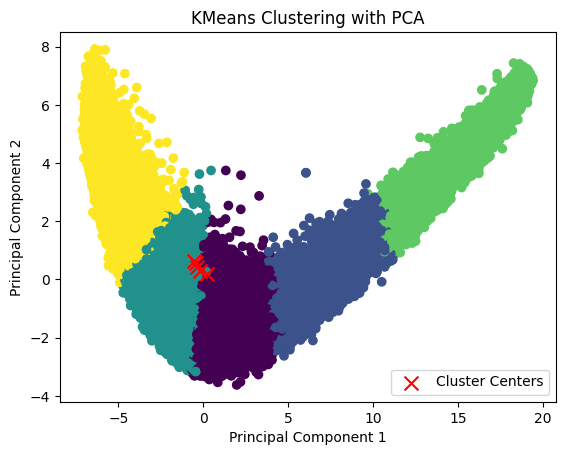

In [34]:
pca = PCA(n_components=2)  # Choose the number of components (e.g., 2 for 2D visualization)
data_reduced = pca.fit_transform(np.asarray(X_train_resampled['embeddings'].to_list()))
# Assuming data_reduced has two components (2D data)
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=cluster_labels, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', s=100, c='red', label='Cluster Centers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering with PCA')
plt.legend()
plt.show()

In [35]:
X_train_resampled.head()

,bug_id,summary,severity,labels,summary_preprocessed,embeddings
74717,724241,CSS ::-moz-selection { text-shadow: } is ignored,normal,3,css mozselection textshadow ignored,"[-0.34495136, 0.8811229, 0.1530847, -0.5735746..."
54366,622386,With Inertia enabled scrolling with trackpad r...,major,2,inertia enabled scrolling trackpad right switc...,"[-0.83623374, 0.21388616, 0.017808834, 0.04519..."
5179,387522,Native JSON support,normal,3,native json support,"[0.23375429, 0.08956996, 0.3802375, -0.0522995..."
62872,665387,Remove unused variable document from nsHtml5Tr...,normal,3,remove unused variable document nshtml5treeope...,"[-0.4013328, 0.50295913, -0.43926254, -0.26056..."
8278,402565,JS Reload of iframe parent loads subframe with...,minor,4,js reload iframe parent loads subframe old que...,"[-0.62840354, 0.6220678, -0.4260861, -0.439047..."


In [36]:
# Collect sentences for each cluster
cluster_sentences = [[] for _ in range(K)]
for i, sentence in tqdm(enumerate(X_train_resampled['summary_preprocessed'].to_list())):
    cluster_sentences[cluster_labels[i]].append(sentence)

0it [00:00, ?it/s]

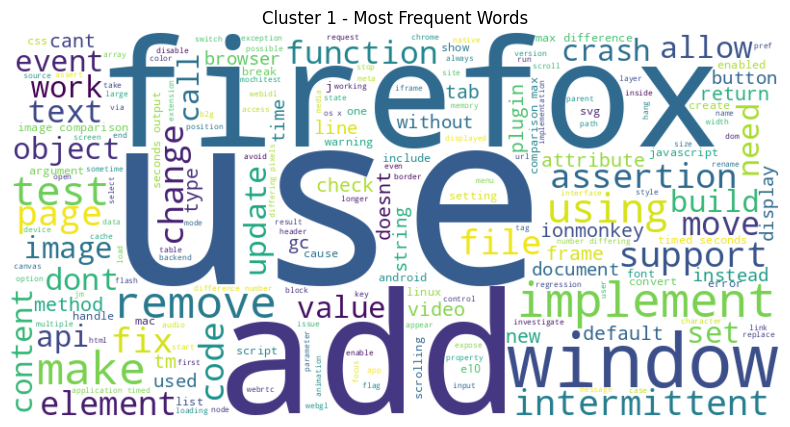

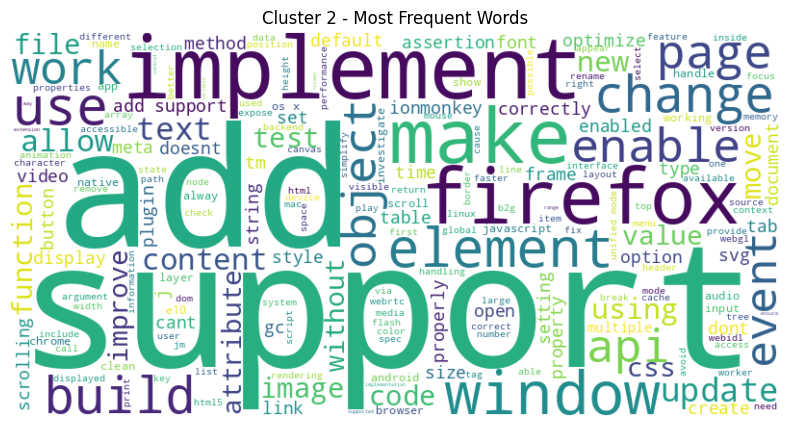

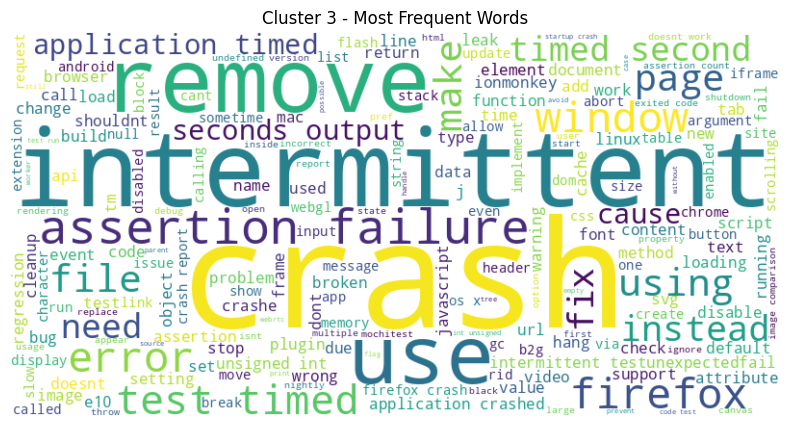

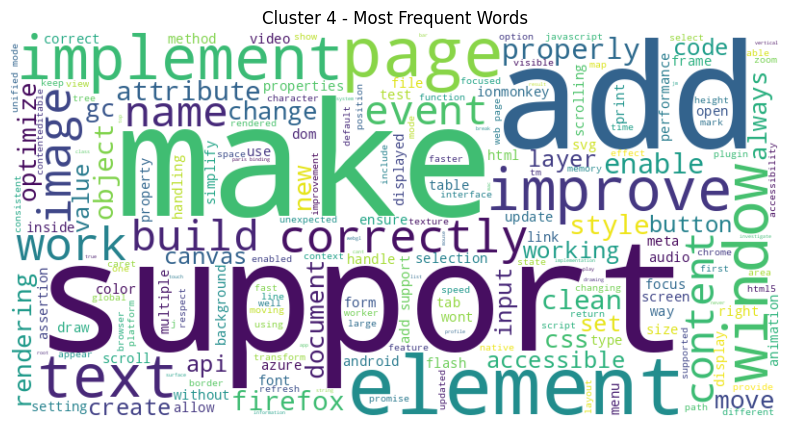

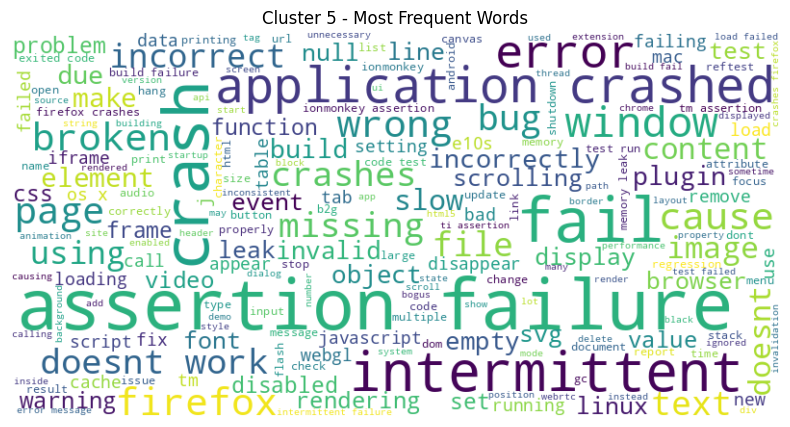

In [37]:
# Tokenize and preprocess sentences in each cluster
cluster_tokenized_sentences = []

cluster_tokenized_sentences = [" ".join(sentences) for sentences in cluster_sentences]
# Word cloud for each cluster
for i, cluster in enumerate(cluster_tokenized_sentences):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Cluster {i+1} - Most Frequent Words")
    plt.show()

In [38]:

# TF-IDF vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_train_resampled['summary_preprocessed'].to_list())
# Collect sentences for each cluster
cluster_sentences = defaultdict(list)
for i, sentence in enumerate(X_train_resampled['summary_preprocessed'].to_list()):
    cluster_sentences[cluster_labels[i]].append(sentence)
# Calculate word frequencies for each cluster (document)
word_frequencies = {}
for cluster, sentences in cluster_sentences.items():
    cluster_text = " ".join(sentences)
    X_cluster = vectorizer.transform([cluster_text])
    word_counts = X_cluster.toarray()[0]
    feature_names = vectorizer.get_feature_names_out()
    word_frequencies[cluster] = {word: count for word, count in zip(feature_names, word_counts) if count > 0}
# Get the most frequent words for each cluster (document)
num_most_frequent = 20  # Choose the number of most frequent words you want to display
most_frequent_words = {}
for cluster, frequencies in word_frequencies.items():
    sorted_frequencies = sorted(frequencies.items(), key=lambda x: x[1], reverse=True)[:num_most_frequent]
    most_frequent_words[cluster] = [word for word, count in sorted_frequencies]
# Print the most frequent words for each cluster (document)
for cluster, words in most_frequent_words.items():
    print(f"Cluster {cluster+1}: {', '.join(words)}")

Cluster 3: crash, intermittent, assertion, remove, test, timed, firefox, failure, error, use, code, const, application, int, doesnt, warning, fix, using, testunexpectedfail, dont
Cluster 1: use, add, firefox, implement, remove, make, support, dont, fix, using, windows, text, assertion, ionmonkey, image, intermittent, video, code, move, page
Cluster 4: support, make, add, correctly, improve, elements, properly, element, implement, text, page, work, name, enable, clean, content, style, css, optimize, working
Cluster 2: support, add, implement, make, firefox, update, enable, api, element, text, use, new, windows, css, improve, build, allow, page, window, work
Cluster 5: failure, assertion, crash, fails, intermittent, crashed, application, error, crashes, doesnt, firefox, wrong, bug, failed, broken, build, incorrect, test, missing, work


In [39]:
cluster_label_map = {0:'trivial',1:'enhancement',2:'minor',3:'normal',4:'major', 5:'blocker', 6:'critical'}
label_list = [cluster_label_map[cluster] for cluster in cluster_labels]

In [40]:
X_train_resampled['category_clustered_predictions'] = label_list
X_train_resampled.head()

,bug_id,summary,severity,labels,summary_preprocessed,embeddings,category_clustered_predictions
74717,724241,CSS ::-moz-selection { text-shadow: } is ignored,normal,3,css mozselection textshadow ignored,"[-0.34495136, 0.8811229, 0.1530847, -0.5735746...",minor
54366,622386,With Inertia enabled scrolling with trackpad r...,major,2,inertia enabled scrolling trackpad right switc...,"[-0.83623374, 0.21388616, 0.017808834, 0.04519...",trivial
5179,387522,Native JSON support,normal,3,native json support,"[0.23375429, 0.08956996, 0.3802375, -0.0522995...",normal
62872,665387,Remove unused variable document from nsHtml5Tr...,normal,3,remove unused variable document nshtml5treeope...,"[-0.4013328, 0.50295913, -0.43926254, -0.26056...",minor
8278,402565,JS Reload of iframe parent loads subframe with...,minor,4,js reload iframe parent loads subframe old que...,"[-0.62840354, 0.6220678, -0.4260861, -0.439047...",minor


get predictions with kmeans

In [41]:
test_data = pd.read_csv("bugs-test.csv")

In [42]:

test_data['summary_preprocessed'] = test_data['summary'].apply(preprocess)


In [44]:
training_embeddings = []
batch_size = 16
for i in tqdm(range(0,len(test_data), batch_size)):
  batch_texts = test_data.iloc[i: i+ batch_size]['summary_preprocessed'].to_list()
  sentence_embeddings = model.encode(batch_texts)
  training_embeddings += list(sentence_embeddings)

test_data['embeddings']= training_embeddings


  0%|          | 0/5381 [00:00<?, ?it/s]

In [55]:
test_data.head()


,bug_id,summary,summary_preprocessed,embeddings
0,1143402,Firefox claims to be not the default browser w...,firefox claims to be not the default browser w...,"[-0.41379598, 0.56418365, -0.33807018, -0.4667..."
1,1143405,Background of html and body element are not ap...,background of html and body element are not ap...,"[-0.26496026, 0.9530972, 0.010389748, -0.32537..."
2,1143409,Mouse input breaks after using window.showModa...,mouse input breaks after using windowshowmodal...,"[-0.87951547, 0.48717088, -0.59153676, -0.1866..."
3,1143411,Build failure with next freetype version/curre...,build failure with next freetype versioncurren...,"[-0.80915016, 0.47094285, -0.07508595, -0.3221..."
4,1143417,HTML element is not treated as root inside for...,html element is not treated as root inside for...,"[-0.27799284, 0.6907609, -0.32170457, -0.49888..."


In [57]:
embeddings_array = np.vstack(test_data['embeddings'])
cluster_labels = kmeans.predict(embeddings_array)

# Add the cluster labels to your DataFrame
test_data['cluster'] = cluster_labels

# Save the DataFrame with predictions back to a CSV file
test_data.to_csv("path_to_your_output_csv_file_with_clusters.csv", index=False)

get predictions of bert

In [58]:
test_data.head()

,bug_id,summary,summary_preprocessed,embeddings,cluster
0,1143402,Firefox claims to be not the default browser w...,firefox claims to be not the default browser w...,"[-0.41379598, 0.56418365, -0.33807018, -0.4667...",2
1,1143405,Background of html and body element are not ap...,background of html and body element are not ap...,"[-0.26496026, 0.9530972, 0.010389748, -0.32537...",2
2,1143409,Mouse input breaks after using window.showModa...,mouse input breaks after using windowshowmodal...,"[-0.87951547, 0.48717088, -0.59153676, -0.1866...",2
3,1143411,Build failure with next freetype version/curre...,build failure with next freetype versioncurren...,"[-0.80915016, 0.47094285, -0.07508595, -0.3221...",4
4,1143417,HTML element is not treated as root inside for...,html element is not treated as root inside for...,"[-0.27799284, 0.6907609, -0.32170457, -0.49888...",0


In [ ]:
# Define the dictionary mapping numeric labels to words
cluster_labels_mapping = {
    0: 'blocker',
    1: 'trivial',
    2: 'normal',
    3: 'critical',
    4: 'enhancement',
    5: 'major',
    6: 'minor'
}

# Replace numeric cluster labels with words
test_data['severity'] = test_data['cluster'].map(cluster_labels_mapping)
columns_to_drop = ['cluster', 'summary_preprocessed', 'summary']
test_data.drop(columns=columns_to_drop, inplace=True)
# Save the DataFrame with cluster words back to a CSV file
test_data.to_csv("predictions.csv", index=False)


In [6]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

output_dir = '/content/drive/MyDrive/your_model_directory'
model = AutoModelForSequenceClassification.from_pretrained(output_dir)
tokenizer = AutoTokenizer.from_pretrained(output_dir)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/your_model_directory and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
import pandas as pd

# Read the CSV file
test_data = pd.read_csv("bugs-test.csv")

# Assuming your text data is in a column named 'text', tokenize it
tokenized_inputs = tokenizer(test_data['summary'].tolist(), padding=True, truncation=True, return_tensors="pt")



In [ ]:
chunk_size = 1000  # Adjust as needed
for i in range(0, len(test_data), chunk_size):
    chunk = test_data.iloc[i:i+chunk_size]
    tokenized_inputs = tokenizer(chunk['summary'].tolist(), padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**tokenized_inputs)
        predictions = outputs.logits.argmax(dim=-1)
    chunk['predictions'] = predictions.tolist()
    chunk.to_csv("output_chunk_{}.csv".format(i), index=False)

<ipython-input-8-af2b80d208ed>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['predictions'] = predictions.tolist()
<ipython-input-8-af2b80d208ed>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['predictions'] = predictions.tolist()
<ipython-input-8-af2b80d208ed>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

In [1]:
import pandas as pd
import glob

# List all the CSV files you want to combine
csv_files = glob.glob("output_chunk_*.csv")

# Read and concatenate all CSV files
combined_df = pd.concat([pd.read_csv(f) for f in csv_files])

# Save the combined DataFrame to a new CSV file
combined_df.to_csv("combined_output.csv", index=False)